This first cell is added by Kaggle by default and contains some useful info/setup to be able to open the data files for the project. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/small-talk-intent-classification-data/Small_talk_Intent.csv


_Now, we read in the data from the csv file that data is held in._

In [2]:
input_data_path = '../input/small-talk-intent-classification-data/Small_talk_Intent.csv'
df = pd.read_csv(input_data_path)
df.head()


,Utterances,Intent
0,who are you?,smalltalk_agent_acquaintance
1,all about you,smalltalk_agent_acquaintance
2,what is your personality,smalltalk_agent_acquaintance
3,define yourself,smalltalk_agent_acquaintance
4,what are you,smalltalk_agent_acquaintance


We split the data here to prevent data leakages. I choose a holdout of 15% percentage with the parameters `test_size` for validation data for testing the model. 

In [3]:
# split data into train and validation sets: df_train and df_val
from sklearn.model_selection import train_test_split

X = df['Utterances'].copy()
y = df['Intent'].copy()

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_raw.head() + "     " + y_train.head()

1801       have you been ready?     smalltalk_agent_ready
1610    are you still working on it?     smalltalk_age...
976          that is incorrect     smalltalk_dialog_wrong
1264    it's my birthday today     smalltalk_user_has_...
1765    do you want to be my best friend?     smalltal...
dtype: object

Here we are vectorizing the data. We are using the TfidfVectorizer() which vectorizies by term-frequency inverse document frequency. In this implementation, we are not removing stop words because the observation are so small. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()

print(f"X_train.shape = {X_train.shape}")
X_val = tfidf_vectorizer.transform(X_val_raw).toarray()
print(f"X_val.shape = {X_val.shape}")
type(X_val)

X_train.shape = (2164, 638)
X_val.shape = (383, 638)


numpy.ndarray

# Model 1 (Decision Tree Classifier)

_The first model I wanted to test was the Decision Tree Classifier. When training, we can see that it fits the training data very well. 99.4% accuracy might be too good of a fit so it will be interesting to see how well it fits the validation data._

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on X_train): 0.9940


In [6]:
predictions_val = model.predict(X_val)
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")


accuracy (on X_train): 0.7206


This result is a pretty good fit for the validation data. I am a little surprised based upon how well the model fit the training data because it felt like the model was going to be overfit. Let's see if we can improve that number by tuning a hyperparameter. For this model, we will tune the min_samples_split.

In [7]:
from sklearn.metrics import log_loss

tune_model = True # can change this to False once you've chosen a hyperparam value and before Saving your notebook with Kaggle
intents = df['Intent'].unique()
# A function to create and fit a RF with a specific number of trees
def tuneModel(hyperparam_value):
    rf_model = DecisionTreeClassifier(min_samples_split=hyperparam_value)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=intents)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=intents)
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter are in the range of 5 to 150 (by 50)
hyp_param_vals = list(range(39,43,1)) # good values for n_estimators
hyp_param_vals = [2,3] + list(range(5, 50, 10)) # good values for min_samples_split
metrics = []

if tune_model:
    for hp in hyp_param_vals:
        metrics.append(tuneModel(hp))

Plot the results of the Decision Tree model performance for the hyperparameter value we looked at which was min_samples_split. Below, you will see that the validation and training data are rather far apart for my liking. It might suggest that there may be a better model to fit the data that does not overfit the training data.

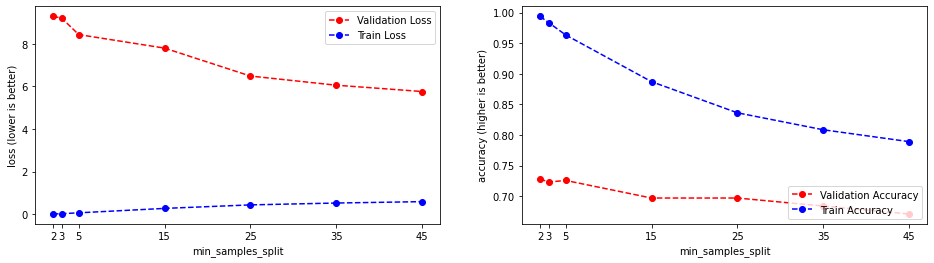

In [8]:
import matplotlib.pyplot as plt

if tune_model:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="min_samples_split", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="min_samples_split", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

To be certain, let's look at the table of values and see which hyperparameter value has the lowest.

In [9]:
# a simple matrix with first row containing hyperparam values, second row containing validation loss, third row containing validation accuracy
# (this could be presented in an even nicer format using a pandas dataframe if you like)
if tune_model:
    tuning_results = np.array([hyp_param_vals, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
    print(tuning_results)

[[ 2.    3.    5.   15.   25.   35.   45.  ]
 [ 9.29  9.21  8.43  7.8   6.49  6.06  5.76]
 [ 0.73  0.72  0.73  0.7   0.7   0.68  0.67]]


After brief analysis of the graphs plotted and the data displayed, we can see that our best choice for min_samples_split was to choose a lower value. For our new value, we will use 2 as the min_samples_split. Also displayed below will be our first couple of predictions.

In [10]:
# refit the model with the best hyperparameter value you found
model = DecisionTreeClassifier(min_samples_split=2)
model = model.fit(X_train, y_train)

# this make predictions for the test set
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_val)
predictions_test[:10]

array(['smalltalk_user_needs_advice', 'smalltalk_agent_clever',
       'smalltalk_user_here', 'smalltalk_agent_crazy',
       'smalltalk_user_likes_agent', 'smalltalk_user_needs_advice',
       'smalltalk_agent_beautiful', 'smalltalk_confirmation_yes',
       'smalltalk_agent_fired', 'smalltalk_agent_busy'], dtype=object)

Let's do one last test of the accuracy. After running the accuracy test we can see marginal improvement as our validation accuracy increased slightly. This move is small but does show some improvement from our tuning.

In [11]:
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")
print(f"accuracy (on X_val): {accuracy_score(y_val, predictions_test):.4f}")

accuracy (on X_train): 0.9940
accuracy (on X_val): 0.7415


# Model 2 (Gaussian Naive Bayes)

_Since the first model seemed to overfit the data a little bit, I wanted to test a second model. The model I chose for this second run was Gaussian Naive Bayes. Below we import the model and train on the same training data that we did before. On intially testing, we can see that we get a significantly lower. Our intially training accuracy was 86.88% which is 12.52% lower than the Decision Tree model._ 

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model = GaussianNB()
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on X_train): 0.8688


Our first run through the validation data was also significantly lower. 66.58% accuracy is also far lower than its Decision tree counterpart. 

In [13]:
predictions_val = model.predict(X_val)
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")

accuracy (on X_train): 0.6658


_Let's tune the model to see if it can yield a more improvement than the Decision Tree model. The hyperparameter we will be tuning is the var_smoothing parameter._

In [14]:
from sklearn.metrics import log_loss

tune_model = True # can change this to False once you've chosen a hyperparam value and before Saving your notebook with Kaggle
intents = df['Intent'].unique()
# A function to create and fit a RF with a specific number of trees
def tuneModel(hyperparam_value):
    rf_model = GaussianNB(var_smoothing=hyperparam_value)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=intents)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=intents)
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter are in the range of 5 to 150 (by 50)
hyp_param_vals = list(range(39,43,1)) # good values for n_estimators
hyp_param_vals = [2,3] + list(range(5, 50, 10)) # good values for min_samples_split
metrics = []

if tune_model:
    for hp in hyp_param_vals:
        metrics.append(tuneModel(hp))

After plotting these tuning runs, we can see that the Gaussian Naive Bayes is a far better fit for the data. The log loss and accuracy are far closer for the test and training data with this model over the Decision Tree Classifier.

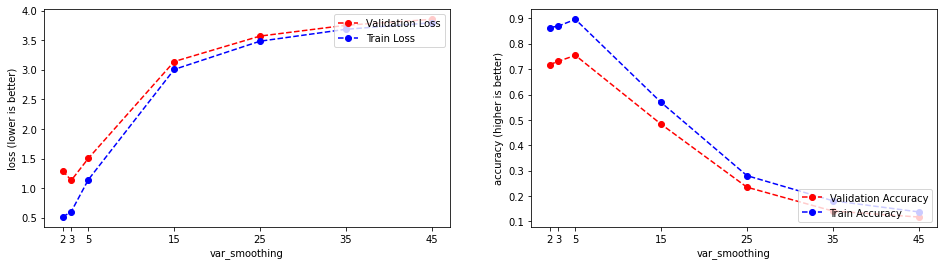

In [15]:
import matplotlib.pyplot as plt

if tune_model:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="var_smoothing", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="var_smoothing", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

Based on the results of the fitting, we can see that the best value for the var_smoothing variable is 5. It is the optimal balance between the log loss and accuracy. Below, we also disply the first couple of predictions for the Gaussian Naive Bayes model with this optimal value.

In [16]:
# refit the model with the best hyperparameter value you found
model = GaussianNB(var_smoothing=5)
model = model.fit(X_train, y_train)

# this make predictions for the test set
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_val)
predictions_test[:10]

array(['smalltalk_agent_bad', 'smalltalk_agent_clever',
       'smalltalk_user_here', 'smalltalk_agent_crazy',
       'smalltalk_user_likes_agent', 'smalltalk_agent_acquaintance',
       'smalltalk_user_looks_like', 'smalltalk_agent_my_friend',
       'smalltalk_user_here', 'smalltalk_agent_busy'], dtype='<U39')

After the tuning and finding the proper hyperparemeter for the model, we now yield a more accurate model than the decision tree classifier. This improvement is far greater than the Decision Tree Classifier and the original untuned model. It will be interesting to see if a deep learning model can improve upon a 75.46% accuracy.

In [17]:
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")
print(f"accuracy (on X_val): {accuracy_score(y_val, predictions_test):.4f}")

accuracy (on X_train): 0.8965
accuracy (on X_val): 0.7546
